# Detección de Impago (German Credit): Optimización de Coste Fijo (CSL)

## Objetivo del Notebook

Este notebook aborda de manera sistemática el **Aprendizaje Sensible a Costes (CSL)** utilizando una estrategia de **Coste Fijo** (`class_weight`). El objetivo es encontrar el factor de penalización óptimo para la clase "Mal Riesgo" (impagos) usando el dataset "German Credit Data".

**Metodología:**
1.  Cargar y preparar el dataset "German Credit".
2.  Establecer un **benchmark convencional** (sin CSL) para tener una línea base.
3.  Implementar `GridSearchCV` para probar sistemáticamente 11 factores de penalización distintos y encontrar el coste óptimo.
4.  Comparar el rendimiento del modelo convencional, el modelo con coste óptimo (CSL) y un modelo con balanceo de datos (SMOTE).

In [8]:
# --- Librerías para manipulación de datos y numéricas ---
import pandas as pd
import numpy as np

# --- Librerías para visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Módulos de Scikit-Learn para Machine Learning ---
# Para dividir los datos
from sklearn.model_selection import train_test_split
# Para preprocesar los datos (escalar y codificar)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Métricas para evaluar los modelos
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, classification_report


## 1. Carga y Preparación de Datos

Cargamos el dataset "German Credit Data" desde el repositorio de UCI. La variable objetivo `class` se mapea para que **0 = Buen Riesgo** (mayoritaria) y **1 = Mal Riesgo** (minoritaria/positiva).

Como muestra el conteo de valores, el dataset está desbalanceado (**700 vs. 300**), lo que justifica el uso de técnicas especiales.

In [9]:
# URL del dataset German Credit Data en el repositorio de UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Los nombres de las columnas se definen según la documentación del dataset
column_names = [
    'existing_checking_account', 'duration_in_month', 'credit_history', 'purpose',
    'credit_amount', 'savings_account_bonds', 'present_employment_since',
    'installment_rate_in_percentage_of_disposable_income',
    'personal_status_and_sex', 'other_debtors_guarantors', 'present_residence_since',
    'property', 'age_in_years', 'other_installment_plans', 'housing',
    'number_of_existing_credits_at_this_bank', 'job', 'number_of_people_being_liable_to_provide_maintenance_for',
    'telephone', 'foreign_worker', 'class'
]

# Leemos los datos, el archivo original no tiene cabecera y usa espacios como separadores.
df = pd.read_csv(url, sep=' ', header=None, names=column_names)

# La columna 'class' es nuestro objetivo (la que queremos predecir).
# Originalmente 1 = Buen riesgo y 2 = Mal riesgo.
# Lo cambiamos para que sea más entendible de forma que:
# 0 = Buen riesgo (clase negativa)
# 1 = Mal riesgo (clase positiva, la que nos interesa detectar)
df['class'] = df['class'].map({1: 0, 2: 1})

# Mostramos las primeras 5 filas para verificar que se cargó bien
print("--- Primeras 5 filas del dataset ---")
display(df.head())

# Vemos cuántos casos hay de cada clase. ¡Es un dataset desbalanceado!
print("\n--- Distribución de la clase objetivo ---")
print(df['class'].value_counts())

--- Primeras 5 filas del dataset ---


,existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account_bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors_guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1



--- Distribución de la clase objetivo ---
class
0    700
1    300
Name: count, dtype: int64


## 2. Preprocesamiento y División de Datos

Se define un `ColumnTransformer` para manejar las variables:
* **Variables Numéricas:** Se escalan con `StandardScaler`.
* **Variables Categóricas:** Se codifican con `OneHotEncoder`.

Luego, los datos se dividen en un 70% para entrenamiento (700 muestras) y un 30% para prueba (300 muestras), usando `stratify=y` para mantener la proporción 70/30 en ambos conjuntos.

In [10]:
# 1. Separamos las características (X) de la variable objetivo (y)
X = df.drop('class', axis=1)
y = df['class']

# 2. Identificamos qué columnas son numéricas y cuáles son categóricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# 3. Creamos el "preprocesador"
# Es un objeto que sabe qué hacer con cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        # Al tuple ('num', ...) le decimos: aplica StandardScaler a las columnas numéricas
        ('num', StandardScaler(), numerical_features),
        # Al tuple ('cat', ...) le decimos: aplica OneHotEncoder a las columnas categóricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Dividimos los datos en entrenamiento (70%) y prueba (30%)
# random_state=42 asegura que la división sea siempre la misma (reproducibilidad)
# stratify=y mantiene la misma proporción de buenos/malos en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Datos listos y divididos.")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Datos listos y divididos.
Tamaño del conjunto de entrenamiento: 700 muestras
Tamaño del conjunto de prueba: 300 muestras


Primero, entrenamos los modelos (Regresión Logística, Árbol, Random Forest, SVC) sin ninguna técnica de sensibilización (`class_weight=None`).

Esto nos da la **línea base** para medir el rendimiento. El objetivo es ver cuántos **Falsos Negativos (FN)** —los errores más costosos— cometen los modelos estándar antes de aplicar optimizaciones.

**Resultados Línea Base (Regresión Logística):**
* **Balanced Accuracy:** 0.7119
* **F1-Score (Mal Riesgo):** 0.596
* **Falsos Negativos (FN):** 42. Este es el número a batir.

--- Resultados para: Regresión Logística ---
Balanced Accuracy: 0.7119
F1 Score: 0.5963

Reporte de Clasificación:
              precision    recall  f1-score   support

 Buen Riesgo       0.82      0.89      0.85       210
  Mal Riesgo       0.68      0.53      0.60        90

    accuracy                           0.78       300
   macro avg       0.75      0.71      0.72       300
weighted avg       0.77      0.78      0.78       300



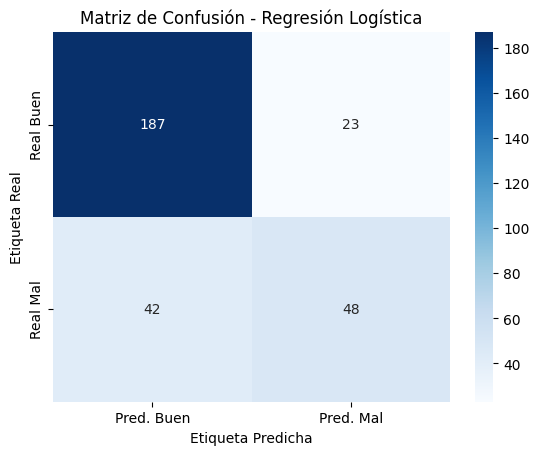

--------------------------------------------------

--- Resultados para: Árbol de Decisión ---
Balanced Accuracy: 0.5937
F1 Score: 0.4348

Reporte de Clasificación:
              precision    recall  f1-score   support

 Buen Riesgo       0.76      0.74      0.75       210
  Mal Riesgo       0.43      0.44      0.43        90

    accuracy                           0.65       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.66      0.65      0.66       300



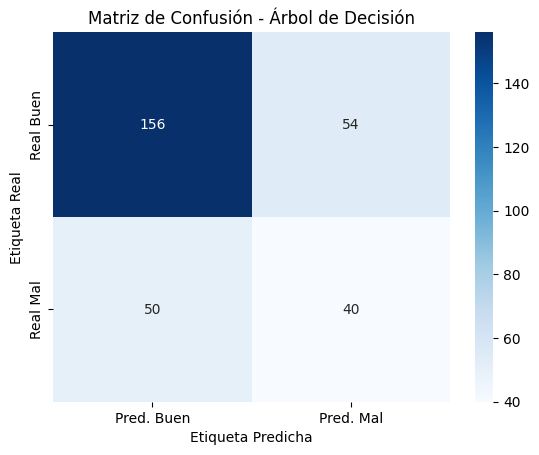

--------------------------------------------------

--- Resultados para: Random Forest ---
Balanced Accuracy: 0.6341
F1 Score: 0.4526

Reporte de Clasificación:
              precision    recall  f1-score   support

 Buen Riesgo       0.77      0.92      0.84       210
  Mal Riesgo       0.66      0.34      0.45        90

    accuracy                           0.75       300
   macro avg       0.71      0.63      0.65       300
weighted avg       0.73      0.75      0.72       300



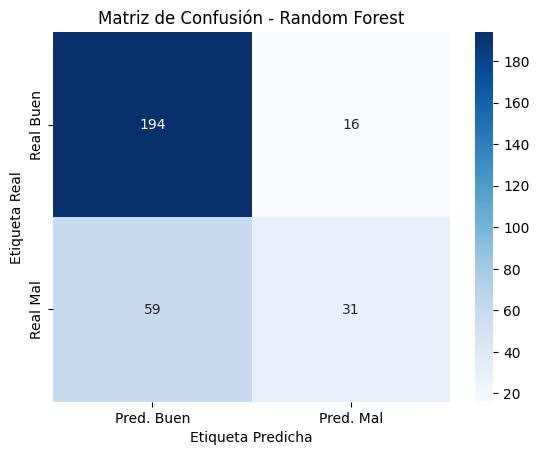

--------------------------------------------------

--- Resultados para: SVC ---
Balanced Accuracy: 0.6722
F1 Score: 0.5248

Reporte de Clasificación:
              precision    recall  f1-score   support

 Buen Riesgo       0.79      0.93      0.85       210
  Mal Riesgo       0.73      0.41      0.52        90

    accuracy                           0.78       300
   macro avg       0.76      0.67      0.69       300
weighted avg       0.77      0.78      0.76       300



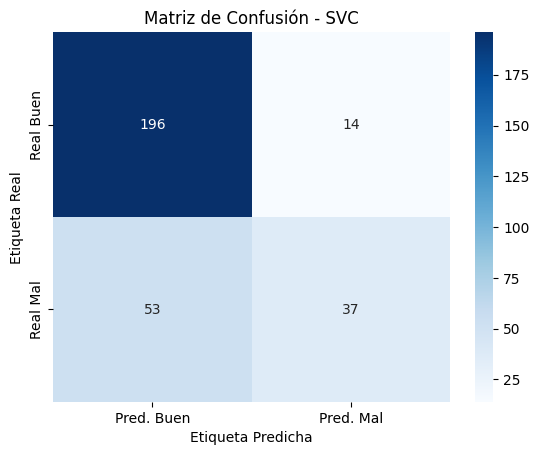

--------------------------------------------------



In [11]:
# Diccionario con los modelos que vamos a probar
models = {
    "Regresión Logística": LogisticRegression(random_state=42, max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42)
}

# Diccionario para los pipelines ya entrenados
fitted_pipelines = {}

# Iteramos sobre cada modelo para entrenarlo y evaluarlo
for name, model in models.items():
    # Creamos un Pipeline: primero preprocesa los datos, luego aplica el modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # 1. Entrenamos el pipeline con los datos de entrenamiento
    pipeline.fit(X_train, y_train)

    # Guardamos el pipeline completo y entrenado
    fitted_pipelines[name] = pipeline
    
    # 2. Hacemos predicciones con los datos de prueba
    y_pred = pipeline.predict(X_test)
    
    # 3. Calculamos y mostramos las métricas
    print(f"--- Resultados para: {name} ---")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Buen Riesgo', 'Mal Riesgo']))
    
    # 4. Visualizamos la Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred. Buen', 'Pred. Mal'], 
                yticklabels=['Real Buen', 'Real Mal'])
    plt.title(f'Matriz de Confusión - {name}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()
    print("-" * 50 + "\n")

## 3. Estrategias de Aprendizaje Sensible a Costes

Para abordar el desbalanceo de clases y el coste de los errores, se explorarán dos estrategias principales, tal como se describe en los objetivos del TFG.

### 3.1. Diferencia entre Balanceo y Coste Sensible

* **Balanceo de Clases (ej. SMOTE, Oversampling):** Modifica los *datos* antes del entrenamiento. Su objetivo es **igualar la representación** de las clases (ej. 50/50), pero no informa al modelo sobre el *impacto económico* de un error.
* **Aprendizaje Sensible a Costes (CSL):** No modifica los datos. Modifica la *función de coste* del algoritmo para penalizar más los errores en la clase minoritaria (ej. 'Mal Riesgo'). Esto es crucial porque en un contexto crediticio, un Falso Negativo (no detectar un impago) es mucho más costoso que un Falso Positivo (rechazar un buen cliente).

### 3.2. Métodos de Coste Sensible

1.  **Ponderación de Clase (`class_weight`):** Es el método más simple. Asigna un **coste fijo** a todos los errores de una misma clase. Por ejemplo, `class_weight={0: 1, 1: 5}` le dice al modelo que un error en la clase "Mal Riesgo" (1) es 5 veces peor que un error en la clase "Buen Riesgo" (0). `class_weight='balanced'` es una implementación automática de esto, donde el peso es inversamente proporcional a la frecuencia de la clase.

2.  **Ponderación por Muestra (`sample_weight`):** Es el método más avanzado y el núcleo de este TFG. Asigna un **coste variable a cada muestra individual**. Aquí es donde podemos usar el `Amount` (importe) del fraude para que un error en un fraude de 1000€ sea 100 veces más penalizado que un error en un fraude de 10€.

## 4. Estrategia 1: Optimización de Coste Fijo (GridSearchCV)

Ahora implementamos la estrategia principal solicitada: el **Aprendizaje Sensible a Costes (CSL)**.

Tal como se describe en los objetivos del TFG, no basta con usar `class_weight='balanced'`. Se debe encontrar el factor de penalización *óptimo* de forma sistemática. Para ello, usamos `GridSearchCV` para probar 11 valores diferentes para `class_weight` (desde 1.5x hasta 10x, 'balanced' y 'None').

La métrica de optimización (`scoring`) será la **`Balanced Accuracy`**, ya que es la más justa para evaluar el rendimiento en datasets desbalanceados.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score

# --- Aplicar GridSearchCV a TODOS los modelos ---

# 1. Definimos los pipelines base (sin entrenar)
pipelines = {
    "Regresión Logística": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    "Árbol de Decisión": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "SVC": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42))
    ])
}

# 2. Definimos los parámetros de coste para cada modelo
param_grids = {
    "Regresión Logística": {
        'classifier__class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2}, {0: 1, 1: 2.5}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}, {0: 1, 1: 4.5}, {0: 1, 1: 5}, {0: 1, 1: 10}, 'balanced', None]
    },
    "Árbol de Decisión": {
        'classifier__class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2}, {0: 1, 1: 2.5}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}, {0: 1, 1: 4.5}, {0: 1, 1: 5}, {0: 1, 1: 10}, 'balanced', None]
    },
    "Random Forest": {
        'classifier__class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2}, {0: 1, 1: 2.5}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}, {0: 1, 1: 4.5}, {0: 1, 1: 5}, {0: 1, 1: 10}, 'balanced', None]
    },
    "SVC": {
        'classifier__class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2}, {0: 1, 1: 2.5}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}, {0: 1, 1: 4.5}, {0: 1, 1: 5}, {0: 1, 1: 10}, 'balanced', None]
    }
}

# 3. Definimos la métrica de optimización
scorer = make_scorer(balanced_accuracy_score)

# Lista para guardar los mejores resultados de cada modelo
best_results = []
all_cv_results = {} # Para guardar todos los resultados

# 4. Iteramos, optimizamos y evaluamos cada modelo
for name, pipeline in pipelines.items():
    print(f"\n Iniciando GridSearchCV para: {name}")
    
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grids[name], 
        scoring=scorer, 
        cv=5, 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Guardar todos los resultados de este modelo
    all_cv_results[name] = pd.DataFrame(grid_search.cv_results_)
    
    # Guardar el mejor resultado
    best_results.append({
        "Modelo": name,
        "Mejor Balanced Accuracy (CV)": grid_search.best_score_,
        "Mejor class_weight": grid_search.best_params_['classifier__class_weight'],
    })
    
    print(f"Mejor Balanced Accuracy (CV): {grid_search.best_score_:.4f}")
    print(f"Mejor Factor de Penalización: {grid_search.best_params_['classifier__class_weight']}")
    print("-" * 50)

# 5. Preparamos comparativa de resultados
print("\n--- Comparativa de los Mejores Parámetros por Modelo ---")
# Verificamos si best_results tiene datos antes de crear el DataFrame
if best_results:
    results_summary_df = pd.DataFrame(best_results).set_index('Modelo')
    display(results_summary_df.sort_values(by='Mejor Balanced Accuracy (CV)', ascending=False))
else:
    print("No hay resultados acumulados en best_results.")

# Lista de modelos que queremos inspeccionar
modelos_a_inspeccionar = ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'SVC']

# Iteramos sobre la lista para mostrar el desglose de cada uno
for nombre_modelo in modelos_a_inspeccionar:
    # Verificamos si el modelo existe en nuestro diccionario de resultados
    if nombre_modelo in all_cv_results:
        print(f"\n--- Desglose completo: {nombre_modelo} ---")
        
        # Extraemos el DataFrame del modelo
        df_model = all_cv_results[nombre_modelo]
        
        # Ordenamos por ranking (el mejor score primero)
        df_sorted = df_model.sort_values(by='rank_test_score')
        
        # Mostramos las columnas más relevantes
        # Nota: Asegúrate de que 'param_classifier__class_weight' exista, si usas pipelines a veces el nombre cambia
        cols_to_show = ['param_classifier__class_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']
        
        # Filtramos solo las columnas que existen en el df para evitar errores
        cols_existentes = [col for col in cols_to_show if col in df_sorted.columns]
        
        display(df_sorted[cols_existentes].head(10)) # Mostramos solo el top 10 para no saturar la pantalla
    else:
        print(f"\n⚠️ No se encontraron resultados para: {nombre_modelo}")


 Iniciando GridSearchCV para: Regresión Logística
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Mejor Balanced Accuracy (CV): 0.7027
Mejor Factor de Penalización: {0: 1, 1: 3.5}
--------------------------------------------------

 Iniciando GridSearchCV para: Árbol de Decisión
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Mejor Balanced Accuracy (CV): 0.6500
Mejor Factor de Penalización: {0: 1, 1: 4.5}
--------------------------------------------------

 Iniciando GridSearchCV para: Random Forest
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Mejor Balanced Accuracy (CV): 0.6422
Mejor Factor de Penalización: None
--------------------------------------------------

 Iniciando GridSearchCV para: SVC
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Mejor Balanced Accuracy (CV): 0.7085
Mejor Factor de Penalización: {0: 1, 1: 3.5}
--------------------------------------------------

--- Comparativa de los Mejores Parámetros por Modelo 

,Mejor Balanced Accuracy (CV),Mejor class_weight
Modelo,,
SVC,0.708503,"{0: 1, 1: 3.5}"
Regresión Logística,0.702721,"{0: 1, 1: 3.5}"
Árbol de Decisión,0.650000,"{0: 1, 1: 4.5}"
Random Forest,0.642177,None



--- Desglose completo: Regresión Logística ---


,param_classifier__class_weight,mean_test_score,std_test_score,rank_test_score
4,"{0: 1, 1: 3.5}",0.702721,0.033627,1
3,"{0: 1, 1: 3}",0.696599,0.020650,2
5,"{0: 1, 1: 4}",0.695918,0.025891,3
7,"{0: 1, 1: 5}",0.695578,0.029750,4
6,"{0: 1, 1: 4.5}",0.695238,0.029719,5
2,"{0: 1, 1: 2.5}",0.689456,0.022526,6
9,balanced,0.684354,0.023408,7
1,"{0: 1, 1: 2}",0.670748,0.029291,8
8,"{0: 1, 1: 10}",0.663605,0.014245,9
0,"{0: 1, 1: 1.5}",0.660884,0.019587,10



--- Desglose completo: Árbol de Decisión ---


,param_classifier__class_weight,mean_test_score,std_test_score,rank_test_score
6,"{0: 1, 1: 4.5}",0.650000,0.048586,1
0,"{0: 1, 1: 1.5}",0.641837,0.045907,2
5,"{0: 1, 1: 4}",0.638435,0.046508,3
7,"{0: 1, 1: 5}",0.636735,0.041555,4
9,balanced,0.635714,0.032041,5
8,"{0: 1, 1: 10}",0.628571,0.041037,6
1,"{0: 1, 1: 2}",0.625850,0.040745,7
2,"{0: 1, 1: 2.5}",0.625850,0.027528,7
4,"{0: 1, 1: 3.5}",0.621769,0.031591,9
3,"{0: 1, 1: 3}",0.619048,0.023541,10



--- Desglose completo: Random Forest ---


,param_classifier__class_weight,mean_test_score,std_test_score,rank_test_score
10,None,0.642177,0.019468,1
1,"{0: 1, 1: 2}",0.637075,0.019792,2
5,"{0: 1, 1: 4}",0.633333,0.027771,3
9,balanced,0.630272,0.031092,4
8,"{0: 1, 1: 10}",0.628912,0.033351,5
3,"{0: 1, 1: 3}",0.625170,0.020425,6
7,"{0: 1, 1: 5}",0.624490,0.028282,7
2,"{0: 1, 1: 2.5}",0.621088,0.026356,8
0,"{0: 1, 1: 1.5}",0.620408,0.024181,9
6,"{0: 1, 1: 4.5}",0.617347,0.032429,10



--- Desglose completo: SVC ---


,param_classifier__class_weight,mean_test_score,std_test_score,rank_test_score
4,"{0: 1, 1: 3.5}",0.708503,0.025535,1
3,"{0: 1, 1: 3}",0.701361,0.043287,2
5,"{0: 1, 1: 4}",0.698639,0.024181,3
6,"{0: 1, 1: 4.5}",0.696599,0.022111,4
9,balanced,0.692177,0.025702,5
7,"{0: 1, 1: 5}",0.690136,0.028282,6
2,"{0: 1, 1: 2.5}",0.689796,0.034143,7
1,"{0: 1, 1: 2}",0.687415,0.013707,8
8,"{0: 1, 1: 10}",0.685374,0.032034,9
0,"{0: 1, 1: 1.5}",0.665986,0.031773,10


### 4.1. Resultados del GridSearchCV

Los resultados de la optimización (celda 6) son claros:

* **Mejores Modelos:** **SVC** (0.7085) y **Regresión Logística** (0.7027) son los que mejor responden al CSL.
* **Factor Óptimo:** Ambos alcanzan su rendimiento máximo con un factor de penalización de **3.5x** para la clase "Mal Riesgo" (`{0: 1, 1: 3.5}`).
* **'balanced' no es el óptimo:** El desglose de la Regresión Logística muestra que `balanced` (factor ~2.33x) obtuvo un score de 0.684, demostrando que la optimización con GridSearch aporta un valor real.
* **Random Forest:** Este modelo (basado en *bagging*) no responde bien a `class_weight` y obtiene su mejor score con `None` (convencional).

## 5. Comparativa Final de Estrategias (CSL vs. SMOTE vs. Convencional)

Ahora que hemos encontrado el factor de coste óptimo (3.5x), realizamos la comparativa final en el conjunto de prueba, **centrándonos en el `F1-Score (Mal Riesgo)`** y los FN.

Comparamos tres enfoques usando la Regresión Logística:
1.  **Modelo 1: Convencional** (Línea Base).
2.  **Modelo 2: Coste Sensible Óptimo** (Del `GridSearchCV`, `class_weight=3.5x`).
3.  **Modelo 3: Balanceo de Datos (SMOTE)** (Usando `ImbPipeline`).

Comparando Estrategias: Convencional vs. Coste Sensible vs. SMOTE (Balanceo)

Entrenando Modelo 1: Convencional...
Evaluando Modelo 2: Coste Sensible (Mejor de GridSearchCV)...
Entrenando Modelo 3: Balanceo (SMOTE)...

--- Tabla Comparativa de Estrategias (German Credit / Regresión Logística) ---


,Balanced Accuracy,F1 (Mal Riesgo),FN (Costosos),FP
Estrategia,,,,
3. Balanceo (SMOTE),0.740476,0.631579,24,53
"2. Coste Sensible (Mejor: {0: 1, 1: 3.5})",0.723016,0.609442,19,72
1. Convencional (Accuracy),0.711905,0.596273,42,23


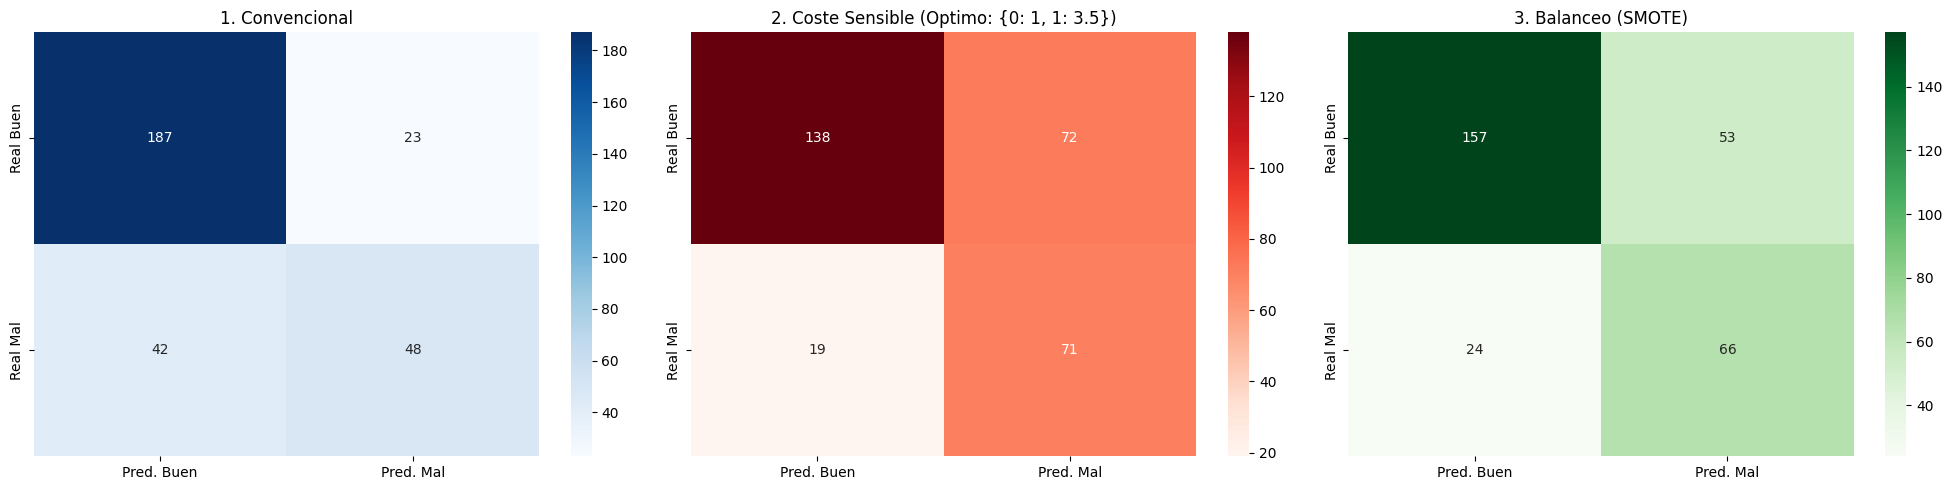

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Comparar (1) Convencional, (2) Coste Sensible, y (3) Balanceo (SMOTE) ---
print("Comparando Estrategias: Convencional vs. Coste Sensible vs. SMOTE (Balanceo)")

# Reutilizamos las variables X_train, y_train, X_test, y_test del notebook.

# --- 1. Modelo Convencional (Sin pesos) ---
print("\nEntrenando Modelo 1: Convencional...")
# Usaremos Regresión Logística como base para una comparación justa
pipeline_conv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight=None)) # class_weight=None es el convencional
])
pipeline_conv.fit(X_train, y_train)
y_pred_conv = pipeline_conv.predict(X_test)
metrics_conv = {
    "Estrategia": "1. Convencional (Accuracy)",
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_conv),
    "F1 (Mal Riesgo)": f1_score(y_test, y_pred_conv),
    "FN (Costosos)": confusion_matrix(y_test, y_pred_conv).ravel()[2],
    "FP": confusion_matrix(y_test, y_pred_conv).ravel()[1]
}


# --- 2. Modelo de Coste Sensible (El mejor del GridSearch) ---
print("Evaluando Modelo 2: Coste Sensible (Mejor de GridSearchCV)...")
# 'grid_search' es la variable de la celda anterior que contiene los resultados del GridSearchCV
try:
    pipeline_csl = grid_search.best_estimator_
    y_pred_csl = pipeline_csl.predict(X_test)
    metrics_csl = {
        "Estrategia": f"2. Coste Sensible (Mejor: {grid_search.best_params_['classifier__class_weight']})",
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_csl),
        "F1 (Mal Riesgo)": f1_score(y_test, y_pred_csl),
        "FN (Costosos)": confusion_matrix(y_test, y_pred_csl).ravel()[2],
        "FP": confusion_matrix(y_test, y_pred_csl).ravel()[1]
    }
except NameError:
    print("Error: 'grid_search' no está definido. Ejecuta la celda anterior de GridSearchCV primero.")
    metrics_csl = None


# --- 3. Modelo de Balanceo (SMOTE) ---
print("Entrenando Modelo 3: Balanceo (SMOTE)...")
# Usamos ImbPipeline, que aplica SMOTE solo a los datos de entrenamiento (X_train, y_train)
# y no a los de validación (X_test), evitando así el "data leakage".
pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Aplica SMOTE
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Modelo convencional
])
pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)
metrics_smote = {
    "Estrategia": "3. Balanceo (SMOTE)",
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_smote),
    "F1 (Mal Riesgo)": f1_score(y_test, y_pred_smote),
    "FN (Costosos)": confusion_matrix(y_test, y_pred_smote).ravel()[2],
    "FP": confusion_matrix(y_test, y_pred_smote).ravel()[1]
}


# --- 4. Tabla Comparativa Final ---
print("\n--- Tabla Comparativa de Estrategias (German Credit / Regresión Logística) ---")
final_comparison_data = [metrics_conv]
if metrics_csl:
    final_comparison_data.append(metrics_csl)
final_comparison_data.append(metrics_smote)

final_comparison_df = pd.DataFrame(final_comparison_data).set_index('Estrategia')
display(final_comparison_df.sort_values(by='Balanced Accuracy', ascending=False))

# --- 5. Visualización de Matrices de Confusión ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Matriz Convencional
cm_conv = confusion_matrix(y_test, y_pred_conv)
sns.heatmap(cm_conv, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Pred. Buen', 'Pred. Mal'], yticklabels=['Real Buen', 'Real Mal'])
axes[0].set_title('1. Convencional')

# Matriz Coste Sensible
if metrics_csl:
    cm_csl = confusion_matrix(y_test, y_pred_csl)
    sns.heatmap(cm_csl, annot=True, fmt='d', cmap='Reds', ax=axes[1],
                xticklabels=['Pred. Buen', 'Pred. Mal'], yticklabels=['Real Buen', 'Real Mal'])
    axes[1].set_title(f'2. Coste Sensible (Optimo: {grid_search.best_params_["classifier__class_weight"]})')

# Matriz SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred. Buen', 'Pred. Mal'], yticklabels=['Real Buen', 'Real Mal'])
axes[2].set_title('3. Balanceo (SMOTE)')

plt.tight_layout()
plt.show()

## 6. Conclusión Final del Notebook (F1-Score vs. Coste)

El análisis de la tabla y las matrices de confusión revela un *trade-off* fundamental:

1.  **Ganador Estadístico (SMOTE):** La estrategia **SMOTE** obtiene el mejor **`F1-Score` (0.632)** y la mejor **`Balanced Accuracy` (0.7405)**. Logra el equilibrio óptimo entre Precisión y Recall (24 FN vs 53 FP).

2.  **Ganador de Negocio (CSL Óptimo):** La estrategia **CSL 3.5x** obtiene el **mínimo absoluto de Falsos Negativos (19)**. Es el modelo más seguro para el banco. Sin embargo, su `F1-Score` es ligeramente inferior (0.609) porque es *demasiado* agresivo, generando muchos Falsos Positivos (72), lo que baja su Precisión.

3.  **Perdedor (Convencional):** Es el peor en todas las métricas (`F1-Score` 0.596) y tiene el mayor riesgo financiero (42 FN).

**Conclusión:** Para este dataset *moderadamente* desbalanceado, SMOTE es el mejor modelo "estadístico" (mejor F1), mientras que CSL (3.5x) es el mejor modelo "de negocio" (mínimos FN).